# ADULT dataset
*Note: a lot of the code here is replicated or directly taken from skeleton codes provided for the homeworks in COGS118A.

In [1]:
%config InlineBackend.figure_format = 'retina'
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn import svm
from sklearn import preprocessing
from sklearn import neighbors
from sklearn import ensemble
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score

## Data preparation and preprocessing

In [2]:
column_names=['age', 'workclass', 'fnlwgt', 'education', 'education-num', 
              'marital-status', 'occupation', 'relationship',
              'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']

adult_data_df = pd.read_csv('adult.data', names=column_names, 
             sep=',', na_values='?', skipinitialspace=True) # Load adult.data to DataFrame object
adult_test_df  = pd.read_csv('adult.test', names=column_names, 
             sep=',', skiprows=1, na_values='?', skipinitialspace=True) # Load adult.data to DataFrame object

combined_data_df = pd.concat([adult_data_df, adult_test_df]) # Concatinate data
combined_data_df["income"] = combined_data_df["income"].str.replace(".","") # Remove dots at end



### Numerical data
Now, let's take a look at a statistical summary of the numerical data:

In [3]:
combined_data_df.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,48842.000000,4.884200e+04,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1.896641e+05,10.078089,1079.067626,87.502314,40.422382
std,13.710510,1.056040e+05,2.570973,7452.019058,403.004552,12.391444
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.175505e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.781445e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.376420e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.490400e+06,16.000000,99999.000000,4356.000000,99.000000


And also some helpful graphs for the numerical data:

Index(['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a1bd71e48>,
      dtype=object)

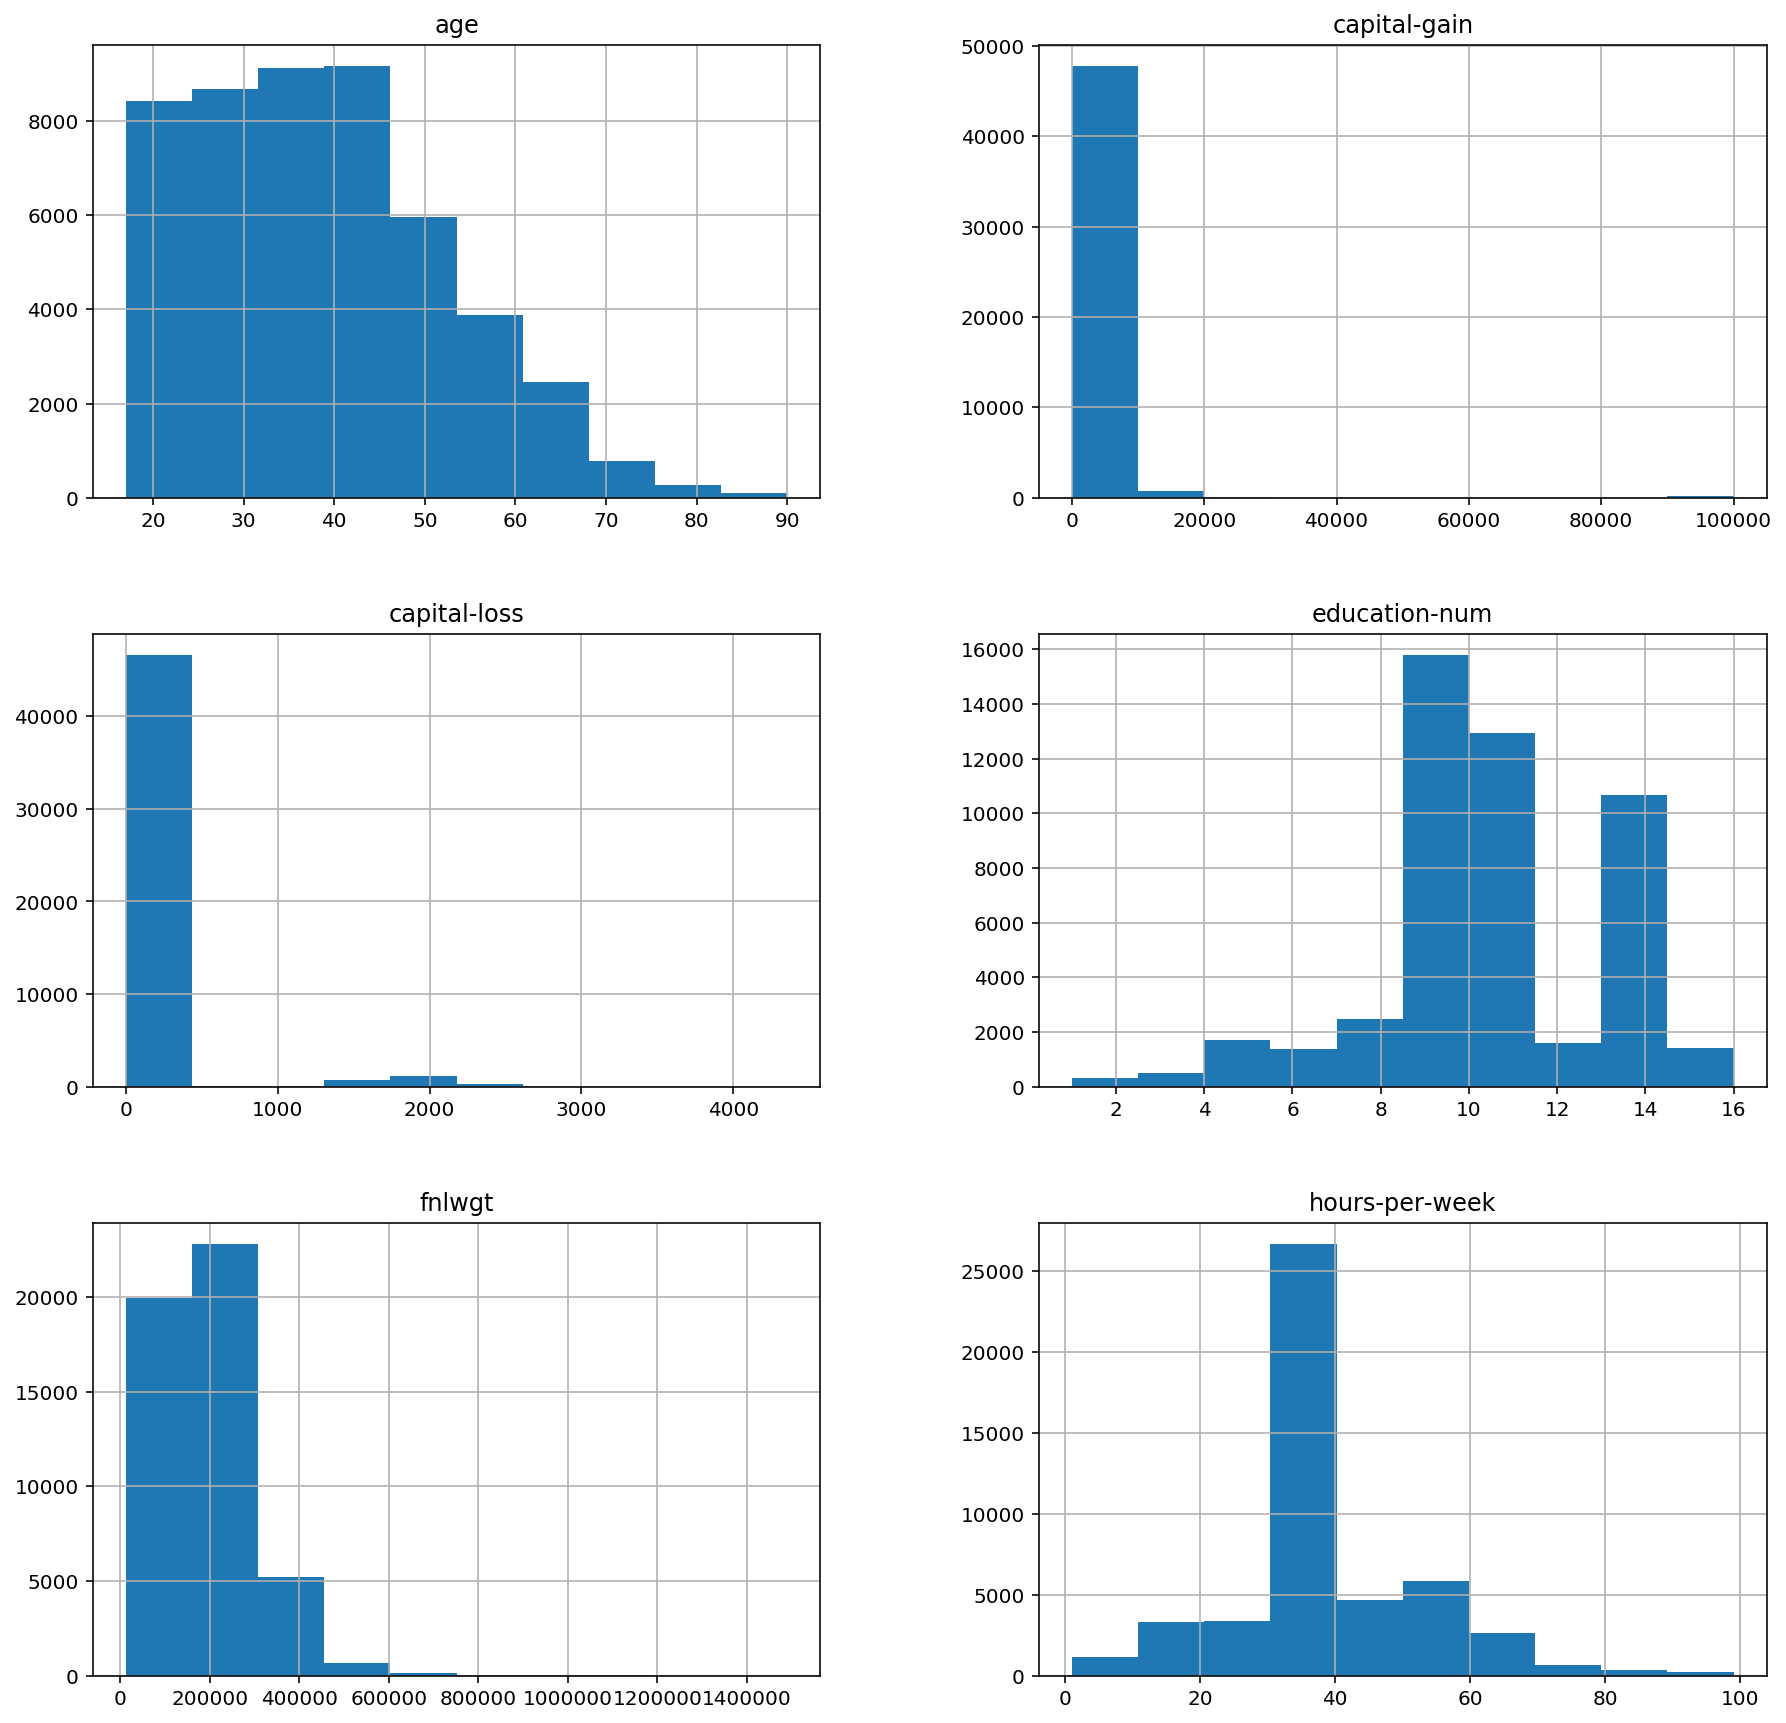

In [4]:
numerical_attr = combined_data_df.select_dtypes(include=['int'])
print(numerical_attr.columns)

numerical_attr.hist(figsize=(15,15))

Because most of the values for capital-gain and capital-loss are zero, I choose to drop this feature.

In [5]:
combined_data_df.drop("capital-gain", axis=1, inplace=True)
combined_data_df.drop("capital-loss", axis=1, inplace=True)

### Categorical data

Let's have a look at the categorical data. The feature 'education-num' is the numerical representation of the categorical feature 'education', so I'll drop it. 

In [6]:
combined_data_df.drop('education', axis=1, inplace=True)

Now I want to get some information about the missing data:

In [7]:
combined_data_df.isna().sum()

age                  0
workclass         2799
fnlwgt               0
education-num        0
marital-status       0
occupation        2809
relationship         0
race                 0
sex                  0
hours-per-week       0
native-country     857
income               0
dtype: int64

I want to see how dropping all of the rows with missing data effects the dataset:

In [8]:
new_dataset= combined_data_df.dropna(inplace=False)
print(new_dataset)

       age         workclass  fnlwgt  education-num      marital-status  \
0       39         State-gov   77516             13       Never-married   
1       50  Self-emp-not-inc   83311             13  Married-civ-spouse   
2       38           Private  215646              9            Divorced   
3       53           Private  234721              7  Married-civ-spouse   
4       28           Private  338409             13  Married-civ-spouse   
...    ...               ...     ...            ...                 ...   
16275   33           Private  245211             13       Never-married   
16276   39           Private  215419             13            Divorced   
16278   38           Private  374983             13  Married-civ-spouse   
16279   44           Private   83891             13            Divorced   
16280   35      Self-emp-inc  182148             13  Married-civ-spouse   

              occupation   relationship                race     sex  \
0           Adm-clerical  No

Because I still have a relatively large number of samples (45222), I choose to remove all of the rows with missing values (i.e. NaN) moving forward:

In [9]:
combined_data_df.dropna(inplace=True) # Shape (45222, 12)
print(combined_data_df)

       age         workclass  fnlwgt  education-num      marital-status  \
0       39         State-gov   77516             13       Never-married   
1       50  Self-emp-not-inc   83311             13  Married-civ-spouse   
2       38           Private  215646              9            Divorced   
3       53           Private  234721              7  Married-civ-spouse   
4       28           Private  338409             13  Married-civ-spouse   
...    ...               ...     ...            ...                 ...   
16275   33           Private  245211             13       Never-married   
16276   39           Private  215419             13            Divorced   
16278   38           Private  374983             13  Married-civ-spouse   
16279   44           Private   83891             13            Divorced   
16280   35      Self-emp-inc  182148             13  Married-civ-spouse   

              occupation   relationship                race     sex  \
0           Adm-clerical  No

Now I'll use one-hot encoding to transform the categorical features into numerical ones:

In [10]:
X_df = combined_data_df.drop("income", axis=1, inplace=False) # Make DataFrame object without labels
X_df = pd.get_dummies(X_df, columns=[
    "workclass", "marital-status", "occupation", "relationship",
    "race", "sex", "native-country"]) # Resulting shape (45222, 86)
print(X_df.shape) 
print(combined_data_df)

(45222, 86)
       age         workclass  fnlwgt  education-num      marital-status  \
0       39         State-gov   77516             13       Never-married   
1       50  Self-emp-not-inc   83311             13  Married-civ-spouse   
2       38           Private  215646              9            Divorced   
3       53           Private  234721              7  Married-civ-spouse   
4       28           Private  338409             13  Married-civ-spouse   
...    ...               ...     ...            ...                 ...   
16275   33           Private  245211             13       Never-married   
16276   39           Private  215419             13            Divorced   
16278   38           Private  374983             13  Married-civ-spouse   
16279   44           Private   83891             13            Divorced   
16280   35      Self-emp-inc  182148             13  Married-civ-spouse   

              occupation   relationship                race     sex  \
0           Adm-

### Normalization
Because many of the features (columns) have different value ranges, I want to normalize the columns so as to avoid some features to more heavily influence my models.

In [11]:
X = X_df.values # NumPy array, shape (45222, 86)
min_max_scaler = preprocessing.MinMaxScaler()
X = min_max_scaler.fit_transform(X)
print(X)

[[0.30136986 0.04335003 0.8        ... 1.         0.         0.        ]
 [0.45205479 0.04727376 0.8        ... 1.         0.         0.        ]
 [0.28767123 0.1368765  0.53333333 ... 1.         0.         0.        ]
 ...
 [0.28767123 0.24476203 0.8        ... 1.         0.         0.        ]
 [0.36986301 0.04766648 0.8        ... 1.         0.         0.        ]
 [0.24657534 0.11419533 0.8        ... 1.         0.         0.        ]]


### Finding X and Y

In [12]:
X = X #already done

# Map income <=50K to -1 and >50K to 1.
combined_data_df['income'] = combined_data_df['income'].map({ "<=50K": -1, ">50K": 1 })
Y = combined_data_df.values[:,-1] # NumPy array, shape (45222, 1)
Y = Y.astype('int')


Let's check how many positives we have (for display purposes).

In [19]:
pos_count = len(list(filter(lambda x: (x >= 0), Y)))
print(pos_count)
print(pos_count/len(Y))

11208
0.2478439697492371


## Main algorithm

In [13]:
partitions=[0.2, 0.8]
C_list = [0.1, 1, 10, 100, 1000]
k_list = [1, 2, 3, 4, 5, 6, 7, 8, 9]
n_estimators = [25, 50, 100]
max_depth = [1, 5, 10]
svm_accuracy=[]
knn_accuracy=[]
random_forest_accuracy=[]

for p in partitions:
    for t in range (3):
        print('-----------------------------------')
        print('\nPartition (% training): ' + str(p*100))
        print('Trial number '+ str(t+1)+'/3')
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=p, random_state=t+1)

        #Linear SVM
        print('\nLinear SVM')
        
        # Cross validate
        estimator = svm.LinearSVC(penalty='l2', loss='hinge', random_state=1024)
        param_grid = {'C': C_list}
        grid_search = GridSearchCV(estimator=estimator, param_grid=param_grid, cv=10)
        grid_search.fit(X_train, Y_train)
        svm_cross_val_results = grid_search.cv_results_
        
        # Train using best hyperperamater(s)
        C = grid_search.best_params_['C']
        classifier = svm.LinearSVC(penalty='l2', loss='hinge', C=C, random_state=1024)
        classifier.fit(X_train, Y_train)
        Y_train_pred = classifier.predict(X_train)
        Y_test_pred = classifier.predict(X_test)
        
        svm_accuracy.append(accuracy_score(Y_train, Y_train_pred))
        svm_accuracy.append(accuracy_score(Y_test, Y_test_pred))
        
        print('Best parameter, C: '+ str(C))
        print(svm_accuracy)
        
        #k-NN
        print('\nk-NN')
        
        # Cross validate
        estimator = neighbors.KNeighborsClassifier()
        param_grid = {'n_neighbors': k_list}
        grid_search = GridSearchCV(estimator, param_grid, cv=5)
        grid_search.fit(X_train, Y_train)
        knn_cross_val_results = grid_search.cv_results_
        
        # Train using best hyperperamater(s)
        k = grid_search.best_params_['n_neighbors']
        classifier = neighbors.KNeighborsClassifier(n_neighbors=k)
        classifier.fit(X_train, Y_train)
        Y_train_pred = classifier.predict(X_train)
        Y_test_pred = classifier.predict(X_test)
        
        knn_accuracy.append(accuracy_score(Y_train, Y_train_pred))
        knn_accuracy.append(accuracy_score(Y_test, Y_test_pred))
        
        print('Best parameter, k: '+str(k))
        print(knn_accuracy)
        
        #Random forest
        print('\nRandom forest')
        
        # Cross validate
        estimator = ensemble.RandomForestClassifier(random_state=1024)
        param_grid = {'n_estimators': n_estimators, 'max_depth': max_depth}
        grid_search = GridSearchCV(estimator, param_grid, cv=5)
        grid_search.fit(X_train, Y_train)
        forest_cross_val_results = grid_search.cv_results_
        
        # Train using best hyperperamater(s)
        n = grid_search.best_params_['n_estimators']
        d = grid_search.best_params_['max_depth']
        classifier = ensemble.RandomForestClassifier(n_estimators=n, max_depth=d, random_state=1024)
        classifier.fit(X_train, Y_train)
        
        # Obtain the training and testing accuracy
        Y_train_pred = classifier.predict(X_train)
        Y_test_pred = classifier.predict(X_test)
        
        random_forest_accuracy.append(accuracy_score(Y_train, Y_train_pred))
        random_forest_accuracy.append(accuracy_score(Y_test, Y_test_pred))
        print('Best parameter, n_estimators: '+str(n))
        print('Best parameter, max_depth: '+str(d))
        print(random_forest_accuracy)
        

-----------------------------------

Partition (% training): 20.0
Trial number 1/3

Linear SVM


/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: L

/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: L

Best parameter, C: 10
[0.8328173374613003, 0.826137431588258]

k-NN
Best parameter, k: 8
[0.8505086245024326, 0.8181767925258444]

Random forest
Best parameter, n_estimators: 100
Best parameter, max_depth: 10
[0.8492923485183547, 0.8264967659903809]
-----------------------------------

Partition (% training): 20.0
Trial number 2/3

Linear SVM


/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: L

/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: L

Best parameter, C: 100
[0.8328173374613003, 0.826137431588258, 0.8311587793011942, 0.8266073304218033]

k-NN
Best parameter, k: 8
[0.8505086245024326, 0.8181767925258444, 0.8559265811587793, 0.8172369948587539]

Random forest
Best parameter, n_estimators: 50
Best parameter, max_depth: 10
[0.8492923485183547, 0.8264967659903809, 0.8512826183104821, 0.8283763613245619]
-----------------------------------

Partition (% training): 20.0
Trial number 3/3

Linear SVM


/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: L

/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: L

Best parameter, C: 10
[0.8328173374613003, 0.826137431588258, 0.8311587793011942, 0.8266073304218033, 0.8334807607253427, 0.8298136989330532]

k-NN
Best parameter, k: 9
[0.8505086245024326, 0.8181767925258444, 0.8559265811587793, 0.8172369948587539, 0.8562582927908006, 0.8148322184753165]

Random forest
Best parameter, n_estimators: 50
Best parameter, max_depth: 10
[0.8492923485183547, 0.8264967659903809, 0.8512826183104821, 0.8283763613245619, 0.8516143299425033, 0.8286804135109735]
-----------------------------------

Partition (% training): 80.0
Trial number 1/3

Linear SVM


/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: L

/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: L

Best parameter, C: 10
[0.8328173374613003, 0.826137431588258, 0.8311587793011942, 0.8266073304218033, 0.8334807607253427, 0.8298136989330532, 0.8287586035326312, 0.8297401879491432]

k-NN
Best parameter, k: 8
[0.8505086245024326, 0.8181767925258444, 0.8559265811587793, 0.8172369948587539, 0.8562582927908006, 0.8148322184753165, 0.8539403488404235, 0.8234383637368712]

Random forest
Best parameter, n_estimators: 100
Best parameter, max_depth: 10
[0.8492923485183547, 0.8264967659903809, 0.8512826183104821, 0.8283763613245619, 0.8516143299425033, 0.8286804135109735, 0.8384332587002792, 0.8318407960199005]
-----------------------------------

Partition (% training): 80.0
Trial number 2/3

Linear SVM


/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: L

/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: L

Best parameter, C: 1
[0.8328173374613003, 0.826137431588258, 0.8311587793011942, 0.8266073304218033, 0.8334807607253427, 0.8298136989330532, 0.8287586035326312, 0.8297401879491432, 0.8298089946651187, 0.825649530127142]

k-NN
Best parameter, k: 9
[0.8505086245024326, 0.8181767925258444, 0.8559265811587793, 0.8172369948587539, 0.8562582927908006, 0.8148322184753165, 0.8539403488404235, 0.8234383637368712, 0.8535810045056251, 0.8227750138197899]

Random forest
Best parameter, n_estimators: 100
Best parameter, max_depth: 10
[0.8492923485183547, 0.8264967659903809, 0.8512826183104821, 0.8283763613245619, 0.8516143299425033, 0.8286804135109735, 0.8384332587002792, 0.8318407960199005, 0.8377145700306825, 0.825428413488115]
-----------------------------------

Partition (% training): 80.0
Trial number 3/3

Linear SVM


/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: L

/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/tomash.spangelo/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: L

Best parameter, C: 10
[0.8328173374613003, 0.826137431588258, 0.8311587793011942, 0.8266073304218033, 0.8334807607253427, 0.8298136989330532, 0.8287586035326312, 0.8297401879491432, 0.8298089946651187, 0.825649530127142, 0.8298919202808415, 0.8302929795467109]

k-NN
Best parameter, k: 9
[0.8505086245024326, 0.8181767925258444, 0.8559265811587793, 0.8172369948587539, 0.8562582927908006, 0.8148322184753165, 0.8539403488404235, 0.8234383637368712, 0.8535810045056251, 0.8227750138197899, 0.8521989109102468, 0.822996130458817]

Random forest
Best parameter, n_estimators: 100
Best parameter, max_depth: 10
[0.8492923485183547, 0.8264967659903809, 0.8512826183104821, 0.8283763613245619, 0.8516143299425033, 0.8286804135109735, 0.8384332587002792, 0.8318407960199005, 0.8377145700306825, 0.825428413488115, 0.8351162340713714, 0.8313985627418463]


### Averaged accuracy
Here I will find the averaged training and testing accuracy with standard deviation for each classifier out of the three trials in each partition.

In [14]:
# Function takes in the list of all accuracies and computes average accordingly + standard deviation
# Format of input: [(Partition1/Trial1/Training), (Partition1/Trial1/Testing), ...,
#                   (Partition2/Trial3/Training), (Partition2/Trial3/Testing)]
def averaged_accuracy(l):
    avg_train_20_l=[]
    avg_test_20_l=[]
    avg_train_80_l=[]
    avg_test_80_l=[]
    for i in range(len(l)):
        if i<6:
            if i%2==0:
                avg_train_20_l.append(l[i])
            else:
                avg_test_20_l.append(l[i])
        else:
            if i%2==0:
                avg_train_80_l.append(l[i])
            else:
                avg_test_80_l.append(l[i])

    avg_train_20 = sum(avg_train_20_l)/3
    avg_train_20_std = np.std(avg_train_20_l)
    avg_test_20 = sum(avg_test_20_l)/3
    avg_test_20_std = np.std(avg_test_20_l)
    avg_train_80 = sum(avg_train_80_l)/3
    avg_train_80_std = np.std(avg_train_80_l)
    avg_test_80 = sum(avg_test_80_l)/3
    avg_test_80_std = np.std(avg_test_80_l)
    return [(avg_train_20, avg_test_20, avg_train_20_std, avg_test_20_std),
            (avg_train_80, avg_test_80, avg_train_80_std, avg_test_80_std )]
    

In [15]:
#SVM
svm_avg_acc = averaged_accuracy(svm_accuracy)
print('SVM')
print('Average accuracy training 20/80: {} +/- {}'.format(svm_avg_acc[0][0], 
                                                          svm_avg_acc[0][2]))
print('Average accuracy testing 20/80: {} +/- {}'.format(svm_avg_acc[0][1],
                                                         svm_avg_acc[0][3]))
print('Average accuracy training 80/20: {} +/- {}'.format(svm_avg_acc[1][0],
                                                          svm_avg_acc[1][2]))
print('Average accuracy testing 80/20: {} +/- {}'.format(svm_avg_acc[1][1],
                                                         svm_avg_acc[1][3]))

#k-NN
knn_avg_acc = averaged_accuracy(knn_accuracy)
print('\nk-NN')
print('Average accuracy training 20/80: {} +/- {}'.format(knn_avg_acc[0][0], 
                                                          knn_avg_acc[0][2]))
print('Average accuracy testing 20/80: {} +/- {}'.format(knn_avg_acc[0][1],
                                                         knn_avg_acc[0][3]))
print('Average accuracy training 80/20: {} +/- {}'.format(knn_avg_acc[1][0],
                                                          knn_avg_acc[1][2]))
print('Average accuracy testing 80/20: {} +/- {}'.format(knn_avg_acc[1][1],
                                                         knn_avg_acc[1][3]))

#Random forest
forest_avg_acc = averaged_accuracy(random_forest_accuracy)
print('\nRandom forest')
print('Average accuracy training 20/80: {} +/- {}'.format(forest_avg_acc[0][0], 
                                                          forest_avg_acc[0][2]))
print('Average accuracy testing 20/80: {} +/- {}'.format(forest_avg_acc[0][1],
                                                         forest_avg_acc[0][3]))
print('Average accuracy training 80/20: {} +/- {}'.format(forest_avg_acc[1][0],
                                                          forest_avg_acc[1][2]))
print('Average accuracy testing 80/20: {} +/- {}'.format(forest_avg_acc[1][1],
                                                         forest_avg_acc[1][3]))
    

SVM
Average accuracy training 20/80: 0.8324856258292791 +/- 0.0009765326035302423
Average accuracy testing 20/80: 0.8275194869810383 +/- 0.0016335559553763432
Average accuracy training 80/20: 0.8294865061595305 +/- 0.0005158170477477967
Average accuracy testing 80/20: 0.8285608992076653 +/- 0.00207098158367086

k-NN
Average accuracy training 20/80: 0.8542311661506709 +/- 0.002635715638918039
Average accuracy testing 20/80: 0.8167486686199715 +/- 0.0014084011695248866
Average accuracy training 80/20: 0.8532400880854318 +/- 0.0007506972404960507
Average accuracy testing 80/20: 0.8230698360051593 +/- 0.00027578090191811354

Random forest
Average accuracy training 20/80: 0.8507297655904468 +/- 0.0010253890419610696
Average accuracy testing 20/80: 0.8278511802753054 +/- 0.0009657261428311129
Average accuracy training 80/20: 0.8370880209341109 +/- 0.001424800787246219
Average accuracy testing 80/20: 0.8295559240832873 +/- 0.002924169437977103


### Draw heatmap
Heatmap showing cross validation accuracy for each combination of hyperparameters for the third trial on 80/20 split for each classifier.

#### SVM

Best parameter, C: 10


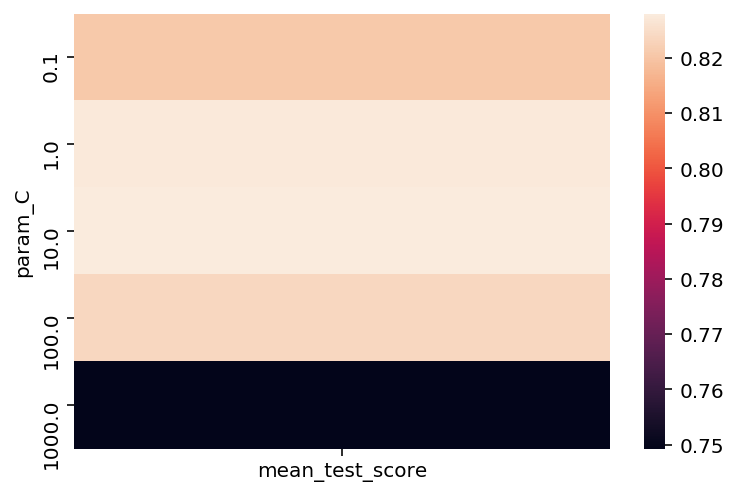

In [16]:
# SVM, trial 3, partion 80/20
pvt_forest = pd.pivot_table(pd.DataFrame(svm_cross_val_results),
    values='mean_test_score', index='param_C')
sns.heatmap(pvt_forest)
print("Best parameter, C: {}".format(C))

#### k-NN

Best parameter, n neighbors (k): 9


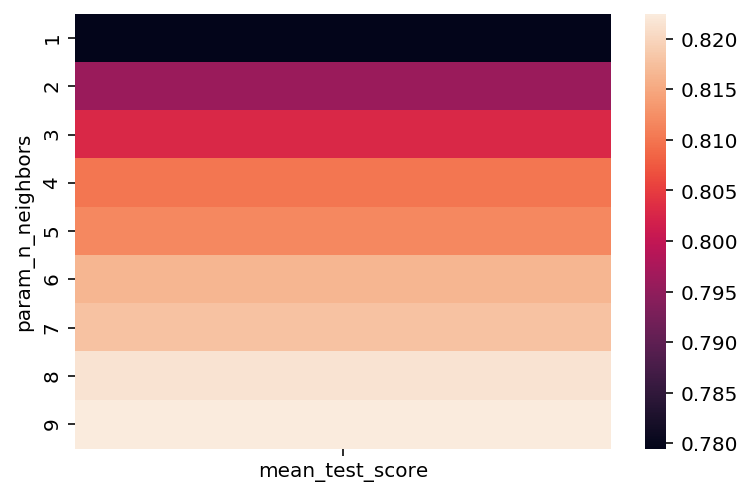

In [17]:
# k-NN, trial 3, partion 80/20
pvt_forest = pd.pivot_table(pd.DataFrame(knn_cross_val_results),
    values='mean_test_score', index='param_n_neighbors')
sns.heatmap(pvt_forest)
print("Best parameter, n neighbors (k): {}".format(k))


#### Random forest

Best parameter, n_estimators: 100
Best parameter, max_depth: 10


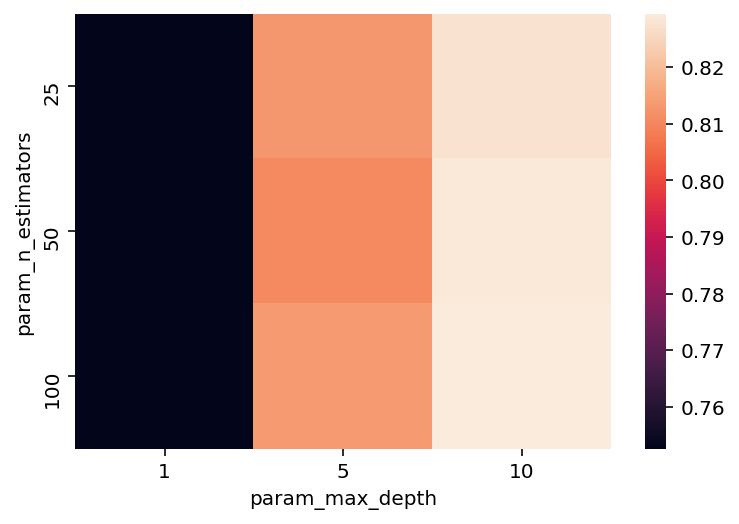

In [18]:
# Random forest, trial 3, partion 80/20
pvt_forest = pd.pivot_table(pd.DataFrame(forest_cross_val_results),
    values='mean_test_score', index='param_n_estimators', columns='param_max_depth')
sns.heatmap(pvt_forest)
print("Best parameter, n_estimators: {}".format(n))
print("Best parameter, max_depth: {}".format(d))
